In [1]:
# import base64
# import imageio
from env.TFenv import HangmanEnvironment

import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf

from tf_agents.agents.dqn.dqn_agent import DqnAgent, DdqnAgent
from tf_agents.networks.q_network import QNetwork

from tf_agents.environments import suite_gym


from tf_agents.environments import tf_py_environment

from tf_agents.policies.random_tf_policy import RandomTFPolicy
from tf_agents.replay_buffers.tf_uniform_replay_buffer import TFUniformReplayBuffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common
from multiprocessing import Pool



In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# print(device_lib.list_local_devices())


Num GPUs Available:  0


In [4]:
# Globals
NUMBER_EPOSODES = 250000
COLLECTION_STEPS = 1
BATCH_SIZE = 64
EVAL_EPISODES = 30
EVAL_INTERVAL = 1000

dictionary_path = "../../../properties/words_250000_train.txt"
reward_map = {
    "game_success_reward": 1.00,
    "lose_reward": -0.,
    "guess_success_reward": 0.2,
    "guess_fail_reward": -0.,
    "guess_repeat_reward": -5.,
}
life_initial = 15

train_env = HangmanEnvironment(dictionary_path, reward_map,life_initial)
evaluation_env = HangmanEnvironment(dictionary_path, reward_map,life_initial)

print('Observation Spec:')
print(train_env.time_step_spec().observation)

print('Reward Spec:')
print(train_env.time_step_spec().reward)

print('Action Spec:')
print(train_env.action_spec())

train_env = tf_py_environment.TFPyEnvironment(train_env)
evaluation_env = tf_py_environment.TFPyEnvironment(evaluation_env)




Observation Spec:
BoundedArraySpec(shape=(1, 30), dtype=dtype('int32'), name='game', minimum=-1, maximum=26)
Reward Spec:
ArraySpec(shape=(), dtype=dtype('float32'), name='reward')
Action Spec:
BoundedArraySpec(shape=(), dtype=dtype('int32'), name='letter', minimum=0, maximum=25)


In [5]:
# train_env.action_spec()
train_env.time_step_spec()
log_interval = 200

In [6]:

hidden_layers = (100, 3)
# (100,)

# dqn_network = QNetwork(
#     train_env.observation_spec(),
#     train_env.action_spec(),
#     fc_layer_params=hidden_layers)

ddqn_network = QNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=hidden_layers)

counter = tf.Variable(0)

ddqn_agent = DdqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network = ddqn_network,
    optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=1e-3),
    td_errors_loss_fn = common.element_wise_squared_loss,
    train_step_counter = counter)

ddqn_agent.initialize()

In [7]:

def get_average_reward(environment, policy, episodes=10):

    total_reward = 0.0

    for _ in range(episodes):
        time_step = environment.reset()
        episode_reward = 0.0

        while not time_step.is_last():
        # for _ in range(4):
            action_step = policy.action(time_step)
            # print(action_step.action)
            time_step = environment.step(action_step.action)
            episode_reward += time_step.reward
            # print(time_step.is_last())
    
        total_reward += episode_reward
        avg_reward = total_reward / episodes
    
    return avg_reward.numpy()[0]

class ExperienceReplay(object):
    def __init__(self, agent, enviroment):
        self._replay_buffer = TFUniformReplayBuffer(
            data_spec=agent.collect_data_spec,
            batch_size=enviroment.batch_size,
            max_length=50000)
        
        self._random_policy = RandomTFPolicy(train_env.time_step_spec(),
                                                enviroment.action_spec())
        
        self._fill_buffer(train_env, self._random_policy, steps=100)
        
        self.dataset = self._replay_buffer.as_dataset(
            num_parallel_calls=3, 
            sample_batch_size=BATCH_SIZE, 
            num_steps=2).prefetch(3)

        self.iterator = iter(self.dataset)
    
    def _fill_buffer(self, enviroment, policy, steps):
        for _ in range(steps):
            self.timestamp_data(enviroment, policy)
            
    def timestamp_data(self, environment, policy):
        time_step = environment.current_time_step()
        action_step = policy.action(time_step)
        next_time_step = environment.step(action_step.action)
        timestamp_trajectory = trajectory.from_transition(time_step, action_step, next_time_step)

        self._replay_buffer.add_batch(timestamp_trajectory)




In [8]:
# print(time_step.is_last())
# action_step.action
# time_step = evaluation_env.step(action_step.action)
# time_step.reward
# print(time_step.is_last())

In [9]:

total_reward = 0.0
episodes=10

for _ in range(episodes):
    time_step = evaluation_env.reset()
    episode_reward = 0.0

    while not time_step.is_last():
    # for _ in range(4):
        action_step = ddqn_agent.policy.action(time_step)
        print(chr(int(action_step.action.numpy()) + 97))
        time_step = evaluation_env.step(action_step.action)
        print("".join([chr(int(x) + 97) for x in time_step[3].numpy()[0][0]]))
        episode_reward += time_step.reward
        # print(time_step)

    total_reward += episode_reward
    avg_reward = total_reward / episodes
    


h
{{{{{{{{``````````````````````
h
{{{{{{{{``````````````````````
h
{{{{{{{{``````````````````````
h
{{{{{{{{``````````````````````
h
{{{{{{{{``````````````````````
h
{{{{{{{{``````````````````````
h
{{{{{{{{``````````````````````
h
{{{{{{{{``````````````````````
h
{{{{{{{{``````````````````````
h
{{{{{{{{``````````````````````
h
{{{{{{{{``````````````````````
h
{{{{{{{{``````````````````````
h
{{{{{{{{``````````````````````
h
{{{{{{{{``````````````````````
h
{{{{{{{{``````````````````````
h
{{{{{{{{{`````````````````````
h
{{{{{{{{{`````````````````````
h
{{{{{{{{{`````````````````````
h
{{{{{{{{{`````````````````````
h
{{{{{{{{{`````````````````````
h
{{{{{{{{{`````````````````````
h
{{{{{{{{{`````````````````````
h
{{{{{{{{{`````````````````````
h
{{{{{{{{{`````````````````````
h
{{{{{{{{{`````````````````````
h
{{{{{{{{{`````````````````````
h
{{{{{{{{{`````````````````````
h
{{{{{{{{{`````````````````````
h
{{{{{{{{{`````````````````````
h
{{{{{{{{{`````````````````````
h
{{{h{{{{

In [10]:
print("**********************************")
print("Training DDQN")
print("**********************************")

# def train(agent):
experience_replay = ExperienceReplay(ddqn_agent, train_env)
ddqn_agent.train_step_counter.assign(0)
print("before avg reward")

avg_reward = get_average_reward(evaluation_env, ddqn_agent.policy, EVAL_EPISODES)
print("before iter")
rewards = [avg_reward]
print("before iter")

for _ in range(NUMBER_EPOSODES):
    for _ in range(COLLECTION_STEPS):
        experience_replay.timestamp_data(train_env, ddqn_agent.collect_policy)

    experience, info = next(experience_replay.iterator)
    train_loss = ddqn_agent.train(experience).loss
    # print(f"ddqn_agent: {_}")
    if ddqn_agent.train_step_counter.numpy() % 500 == 0:
        print(ddqn_agent.train_step_counter.numpy())
    if ddqn_agent.train_step_counter.numpy() % EVAL_INTERVAL == 0:
        avg_reward = get_average_reward(evaluation_env, ddqn_agent.policy, EVAL_EPISODES)
        print('Episode {0} - Average reward = {1}, Loss = {2}.'.format(
                ddqn_agent.train_step_counter.numpy(), avg_reward, train_loss))
        rewards.append(avg_reward)
            
    # return rewards, agent, experience_replay

# print("**********************************")
# print("Training DQN")
# print("**********************************")
# dqn_reward = train(dqn_agent)

print("**********************************")
print("DONE")
print("**********************************")
# ddqn_reward, agent = train(ddqn_agent)


67.40001678466797, Loss = 7.7061333656311035.
35500
36000
Episode 36000 - Average reward = -65.63999938964844, Loss = 44.19859313964844.
36500
37000
Episode 37000 - Average reward = -67.39334869384766, Loss = 16.191591262817383.
37500
38000
Episode 38000 - Average reward = -67.24000549316406, Loss = 25.747604370117188.
38500
39000
Episode 39000 - Average reward = -65.80000305175781, Loss = 10.324569702148438.
39500
40000
Episode 40000 - Average reward = -67.08000183105469, Loss = 38.028289794921875.
40500
41000
Episode 41000 - Average reward = -67.56002044677734, Loss = 24.12030029296875.
41500
42000
Episode 42000 - Average reward = -65.63999938964844, Loss = 27.2320556640625.
42500
43000
Episode 43000 - Average reward = -67.56001281738281, Loss = 27.436986923217773.
43500
44000
Episode 44000 - Average reward = -65.31999969482422, Loss = 34.048885345458984.
44500
45000
Episode 45000 - Average reward = -66.43333435058594, Loss = 34.90648651123047.
45500
46000
Episode 46000 - Average rew

In [12]:
# # train_env.render()
import logging
logging.basicConfig(format='%(levelname)s:%(message)s',
                    level=logging.DEBUG)
ddqn_agent.train_step_counter.numpy()
# time_step = train_env.current_time_step()
# print(time_step)
# print("".join([chr(int(x)+97) for x in time_step[3][0][0]]).replace("{",".").replace('`',""))

# action_step = ddqn_agent.policy.action(time_step)
# action_step

250000

(-2.0, 1.0)

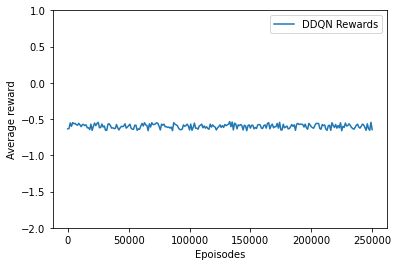

In [13]:
episodes = range(0, NUMBER_EPOSODES + 1, EVAL_INTERVAL)
plt.plot(episodes, rewards, label = 'DDQN Rewards')
plt.legend()
plt.ylabel('Average reward')
plt.xlabel('Epoisodes')
plt.ylim(top=1, bottom=-2)


In [ ]:
https://www.tensorflow.org/agents/tutorials/3_policies_tutorial

In [ ]:
.23# # save policy
# PolicySaver(eval_policy).save(model_dir + 'eval_policy')
# ...
# # load policy
# policy = tf.saved_model.load(model_path)
# action = policy.action(timestep)


In [ ]:
tempdir = os.getenv("TEST_TMPDIR", tempfile.gettempdir())
checkpoint_dir = os.path.join(tempdir, 'checkpoint')
train_checkpointer = common.Checkpointer(
    ckpt_dir=checkpoint_dir,
    max_to_keep=1,
    agent=agent,
    policy=agent.policy,
    replay_buffer=ExperienceReplay,
)
train_checkpointer.save()



In [ ]:
policy_dir = os.path.join(tempdir, 'policy')
tf_policy_saver = policy_saver.PolicySaver(agent.policy)
tf_policy_saver.save(policy_dir)
